
## Chemiluminescence-(extracting temperature at different positions for various velocities)

### Usage:
This code is used to determine the temperature at different positions for various velocities.

Quantify temperatures at individual locations (e.g. -2, 0, etc.), and plot results as a function of velocity.


In [1]:
import numpy as np
import pandas as pd
import glob
import scipy as sc
import matplotlib.pylab as plt
%matplotlib inline
import inspect
#%config InlineBackend.figure_formats = ["retina"]
from scipy.optimize import curve_fit
import microfit.database as db
import microfit.hdr as hdr
import microfit.chemiluminescence as chem
import microfit.pyrometry as pyro
#import microfit.analysis as anls
from microfit import analysis
from scipy import stats
from matplotlib.pyplot import figure
import pywt as pw
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
import math
#from scipy import opQtimize as opt
from importlib import reload
import matplotlib.gridspec as gsp
from  matplotlib.ticker import MultipleLocator
import matplotlib as mpl
import warnings
warnings.filterwarnings(action='once')
from operator import itemgetter
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from PyAstronomy import pyasl
import statistics as ss
#warnings.filterwarnings(action='error')

C:\Users\Navid\Anaconda3\lib\site-packages\astropy\io\fits\header.py:1907: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  collections.MutableSequence.register(Header)
C:\Users\Navid\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Navid\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Figure size 640x480 with 0 Axes>

In [2]:
plt.style.use('../manuscript.mplstyle')
plt.rcParams['figure.figsize']

[8.0, 5.5]

In [3]:
show = True

In [4]:
xlsx = '../index_2018_02_PRF_data.xlsx'
df = pd.read_excel(xlsx)




### Select Data for Gaseous Fuels

In [6]:
cases = np.unique(df.case)
cases = [ c for c in cases if c.split('_')[1]=='09']
cases

['2018_09_Air_130psig_12.37O2_1mm', '2018_09_ethane_130psig_12.37O2_1mm']

In [7]:
ix = df.case.isin(cases)
rp = db.Database(df[ix],verbosity=2)

### Functions

In [8]:
#T: T array for mixture with flame
#x: x array for mixture with flame
#n: max level of decomposition by wavelet
#xl: min of x value for wavelet calculation
#xu : max of x value for wavelet calculation
def wv(T,x,xl,xu):
    x1 = find_nearest_index(x,xl)
    x2 = find_nearest_index(x,xu)
    x_new = x[x1:x2-1]
    x_wv = wavelet_domain(x_new)
    T_new = T[x1:x2-1]
    q = []
    for i in range(7):
        ca = pw.wavedec(T_new,wtype,level=i)[0]
        x_wv, ca = equalize(x_wv, ca)
        x_wv = [x_wv[i] for i in range(len(x_wv)) if math.isnan(ca[i]) != True]
        ca = [ca[i] for i in range(len(ca)) if math.isnan(ca[i]) != True]
        FS = [np.mean(T1_new)/np.mean(ca)*ca[i] for i in range(len(ca))]
        f = np.column_stack((x_wv,FS))
        q = np.asarray(list(q) + list(f))
    q = sorted(q, key=itemgetter(0))
    ca_new = [q[i][1] for i in range(len(q))]
    x_wv_new = [q[i][0] for i in range(len(q))]
    return ca_new, x_wv_new

get array a ---> get 1st element of it ----> find the nearest element in a with distance a[0]+d1----> put it in the new array.

In [9]:
def del_extra(a,b,d1):
    a1 = []
    b1 = []
    d = d1
    a1.append(a[0])
    b1.append(b[0])
    for i in range(len(a)):
        c = a[i]+d
        e = find_nearest_index(a,c)
        if a[e]>a1[-1]+d1:
            a1.append(a[e])
            b1.append(b[e])
        else:
            continue
    return a1,b1

Find nearest value index in numpy array

In [10]:
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

Returns the list with largest length

In [11]:
def max_size(array1, array2):
    if len(array1) >= len(array2):
        return array1
    else:
        return array2

Returns the list with smallest length

In [12]:
def min_size(array1, array2):
    if len(array1) >= len(array2):
        return array1
    else:
        return array2

In [13]:
def wavelet_domain(array):
    x = []
    for i in range(len(array)-1):
        if i%2==0:
            x.append((array[i]+array[i+1])/2)
        else:
            continue
    return x

In [14]:
def tpfinders(fs1,fs2,fs3,x1,x2,x3):
    x = []
    fsn = []
    for i in range(2):
        x.append(x1[i])
    x.append(x2[1])
    for i in range(len(x3)):
        if i <= len(x3)-2:
            x.append(x3[i+1])
        else:
            continue
    for i in range(2):
        fsn.append(fs1[i])
    fsn.append(fs2[1])
    for i in range(len(fs3)):
        if i <= len(fs3)-2:
            fsn.append(fs3[i+1])
        else:
            continue
    return fsn, x

In [15]:
def tpfinderfr(fs1,fs2,x1,x2):
    x = []
    fsn = []
    for i in range(3):
        x.append(x1[i])
    for i in range(len(x2)):
        if i <= len(x2)-3:
            x.append(x2[i+2])
        else:
            continue
    for i in range(3):
        fsn.append(fs1[i])
    for i in range(len(fs2)):
        if i <= len(fs2)-3:
            fsn.append(fs2[i+2])
        else:
            continue
    return fsn, x

In [16]:
def equalize(xpos,cd):
    x = len(xpos)
    y = len(cd)
    xpos = np.linspace(xpos[0],xpos[-1], y)
    return [xpos,cd] 

### Assignment of Temperature Profiles

In [17]:
seq1 = rp.find_sequence_by('case', phi=0)
seq1

{'2018_09_Air_130psig_12.37O2_1mm': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14]}

In [18]:
seq2 = rp.find_sequence_by('case', phi=1)
seq2

{'2018_09_ethane_130psig_12.37O2_1mm': [16,
  17,
  18,
  19,
  20,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30]}

In [19]:
folder_name1 = str(cases[0])
folder_name2 = str(cases[1])
print(folder_name1, folder_name2)

2018_09_Air_130psig_12.37O2_1mm 2018_09_ethane_130psig_12.37O2_1mm


In [20]:
reload.__name__

'reload'

In [21]:
_ = reload(pyro)
_ = reload(analysis)

In [22]:
x_ext, x_max, x_ign = rp.get_x_flames(seq1)

Case: 2018_09_Air_130psig_12.37O2_1mm (C:\Users\Navid\1Notebooks_master\fuels\2018_09_Air_130psig_12.37O2_1mm)
 * get_x_flame -> Air_d76.2_v3.3_phi0.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <load_raw> ... generate HDR calibration image: cube0_raw1.tif
    <load_raw> ... generate HDR image: Air_d76.2_v3.3_phi0.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)_raw1.tif
    <perform_analysis> ... creating new `Fourier` object
rejecting apparent diameter: 68.900
0.4921875 0.4921875
rejecting apparent diameter: 68.900
0.4921875 0.4921875
    <extract_filament> ... extracting `Fourier` filament
    <extract_temperature> ... creating `PyroFrame` object
    <load_raw> ... generate HDR calibration image: cube0_raw2.tif
    <load_raw> ... generate HDR image: Air_d76.2_v3.3_phi0.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)_raw2.tif
    <perform_analysis> ... creating new `Fourier` object
    <extract_filament> ... extracting `Fourier` filament
    <extract_flame> 

    <perform_analysis> ... creating new `Fourier` object
rejecting apparent diameter: 68.900
0.4921875 0.4921875
rejecting apparent diameter: 68.900
0.4921875 0.4921875
    <extract_filament> ... extracting `Fourier` filament
    <extract_temperature> ... creating `PyroFrame` object
    <load_raw> ... generate HDR image: Air_d76.2_v8.0_phi0.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)_raw2.tif
    <perform_analysis> ... creating new `Fourier` object
    <extract_filament> ... extracting `Fourier` filament
    <extract_flame> ... creating `FlameFrame` object
 * get_x_flame -> Air_d76.2_v9.0_phi0.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <load_raw> ... generate HDR image: Air_d76.2_v9.0_phi0.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)_raw1.tif
    <perform_analysis> ... creating new `Fourier` object
rejecting apparent diameter: 68.900
0.4921875 0.4921875
rejecting apparent diameter: 68.900
0.4921875 0.4921875
    <extract_filament> ... extracting `Fo

In [23]:
_, _ = rp.extract_temperatures(seq1)

Case: 2018_09_Air_130psig_12.37O2_1mm (C:\Users\Navid\1Notebooks_master\fuels\2018_09_Air_130psig_12.37O2_1mm)
 * extract_temperature -> Air_d76.2_v3.3_phi0.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
 * extract_temperature -> Air_d76.2_v3.4_phi0.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
 * extract_temperature -> Air_d76.2_v3.5_phi0.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
 * extract_temperature -> Air_d76.2_v3.6_phi0.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
 * extract_temperature -> Air_d76.2_v3.8_phi0.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
 * extract_temperature -> Air_d76.2_v4.0_phi0.00_ps130.34_p

In [24]:
_ = reload(chem)
_ = reload(analysis)

In [25]:
frames1 = rp.extract_flames(seq1,camera=2) #,force=True)

Case: 2018_09_Air_130psig_12.37O2_1mm (C:\Users\Navid\1Notebooks_master\fuels\2018_09_Air_130psig_12.37O2_1mm)
 * extract_flame -> Air_d76.2_v3.3_phi0.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
    <extract_filament> ... returning buffered filament
    <extract_flame> ... creating `FlameFrame` object
 * extract_flame -> Air_d76.2_v3.4_phi0.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
    <extract_filament> ... returning buffered filament
    <extract_flame> ... creating `FlameFrame` object
 * extract_flame -> Air_d76.2_v3.5_phi0.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
    <extract_filament> ... returning buffered filament
    <extract_flame> ... creating `FlameFrame` object
 * extract_flame -> Air_d76.2_v3.6_phi0.00_ps130.34_pa130.400000_pref6.030000_(ve160_

In [26]:
inspect.getsourcefile(rp.extract_flames)

'C:\\Users\\Navid\\Anaconda3\\lib\\site-packages\\microfit\\database.py'

In [27]:
reload.__name__

'reload'

In [28]:
_ = reload(pyro)
_ = reload(analysis)

In [29]:
x_ext, x_max, x_ign = rp.get_x_flames(seq2)

Case: 2018_09_ethane_130psig_12.37O2_1mm (C:\Users\Navid\1Notebooks_master\fuels\2018_09_ethane_130psig_12.37O2_1mm)
 * get_x_flame -> Ethane_d76.2_v3.3_phi1.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <load_raw> ... generate HDR calibration image: cube0_raw1.tif
    <load_raw> ... generate HDR image: Ethane_d76.2_v3.3_phi1.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)_raw1.tif
    <perform_analysis> ... creating new `Fourier` object
rejecting apparent diameter: 68.900
0.4921875 0.4921875
rejecting apparent diameter: 68.900
0.4921875 0.4921875
    <extract_filament> ... extracting `Fourier` filament
    <extract_temperature> ... creating `PyroFrame` object
    <load_raw> ... generate HDR calibration image: cube0_raw2.tif
    <load_raw> ... generate HDR image: Ethane_d76.2_v3.3_phi1.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)_raw2.tif
    <perform_analysis> ... creating new `Fourier` object
    <extract_filament> ... extracting `Fourier` filament
    <

    <perform_analysis> ... creating new `Fourier` object
rejecting apparent diameter: 68.900
0.4921875 0.4921875
rejecting apparent diameter: 68.900
0.4921875 0.4921875
    <extract_filament> ... extracting `Fourier` filament
    <extract_temperature> ... creating `PyroFrame` object
    <load_raw> ... generate HDR image: Ethane_d76.2_v8.0_phi1.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)_raw2.tif
    <perform_analysis> ... creating new `Fourier` object
    <extract_filament> ... extracting `Fourier` filament
    <extract_flame> ... creating `FlameFrame` object
 * get_x_flame -> Ethane_d76.2_v9.0_phi1.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <load_raw> ... generate HDR image: Ethane_d76.2_v9.0_phi1.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)_raw1.tif
    <perform_analysis> ... creating new `Fourier` object
rejecting apparent diameter: 68.900
0.4921875 0.4921875
rejecting apparent diameter: 68.900
0.4921875 0.4921875
    <extract_filament> ... extra

In [30]:
_, _ = rp.extract_temperatures(seq2)

Case: 2018_09_ethane_130psig_12.37O2_1mm (C:\Users\Navid\1Notebooks_master\fuels\2018_09_ethane_130psig_12.37O2_1mm)
 * extract_temperature -> Ethane_d76.2_v3.3_phi1.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
 * extract_temperature -> Ethane_d76.2_v3.4_phi1.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
 * extract_temperature -> Ethane_d76.2_v3.5_phi1.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
 * extract_temperature -> Ethane_d76.2_v3.6_phi1.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
 * extract_temperature -> Ethane_d76.2_v3.8_phi1.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
 * extract_temperature -> Ethane_d76.2

In [31]:
_ = reload(chem)
_ = reload(analysis)

In [32]:
frames2 = rp.extract_flames(seq2,camera=2) #,force=True)

Case: 2018_09_ethane_130psig_12.37O2_1mm (C:\Users\Navid\1Notebooks_master\fuels\2018_09_ethane_130psig_12.37O2_1mm)
 * extract_flame -> Ethane_d76.2_v3.3_phi1.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
    <extract_filament> ... returning buffered filament
    <extract_flame> ... creating `FlameFrame` object
 * extract_flame -> Ethane_d76.2_v3.4_phi1.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
    <extract_filament> ... returning buffered filament
    <extract_flame> ... creating `FlameFrame` object
 * extract_flame -> Ethane_d76.2_v3.5_phi1.00_ps130.34_pa130.400000_pref6.030000_(ve160_phie0.65)
    <extract_temperature> ... returning stored pyrometry results
    <extract_filament> ... returning buffered filament
    <extract_flame> ... creating `FlameFrame` object
 * extract_flame -> Ethane_d76.2_v3.6_phi1.00_ps130.34_pa130.400000_pr

In [33]:
n_case1 = len(seq1)
n_vels1 = [len(seq1[k]) for k in seq1][0]
n_case1, n_vels1

(1, 14)

In [34]:
test1 = frames1[folder_name1]

In [35]:
n_vels1

14

In [36]:
frames1.keys()

dict_keys(['2018_09_Air_130psig_12.37O2_1mm'])

In [37]:
len(test1)

14

In [38]:
vel1 = rp.get_entries(seq1, 'v')
print(vel1)

{'2018_09_Air_130psig_12.37O2_1mm': [3.3, 3.4, 3.5, 3.6, 3.8, 4.0, 4.5, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]}


In [39]:
title1 = list(frames1.keys())

In [40]:
rp.get_entries(seq2, 'v')

{'2018_09_ethane_130psig_12.37O2_1mm': [3.3,
  3.4,
  3.5,
  3.6,
  3.8,
  4.0,
  4.5,
  5.0,
  6.0,
  7.0,
  8.0,
  9.0,
  10.0,
  11.0]}

In [41]:
v_f1=vel1[folder_name1]
print(v_f1)

[3.3, 3.4, 3.5, 3.6, 3.8, 4.0, 4.5, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]


In [42]:
n_case2 = len(seq2)
n_vels2 = [len(seq2[k]) for k in seq2][0]
n_case2, n_vels2

(1, 14)

In [43]:
test2 = frames2[folder_name2]

In [44]:
n_vels2

14

In [45]:
frames2.keys()

dict_keys(['2018_09_ethane_130psig_12.37O2_1mm'])

In [46]:
title2 = list(frames2.keys())
title2[0]

'2018_09_ethane_130psig_12.37O2_1mm'

In [47]:
len(test2)

14

In [48]:
vel2 = rp.get_entries(seq2, 'v')
print(vel2)

{'2018_09_ethane_130psig_12.37O2_1mm': [3.3, 3.4, 3.5, 3.6, 3.8, 4.0, 4.5, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]}


In [49]:
v_f2=vel2[folder_name2]
print(v_f2)

[3.3, 3.4, 3.5, 3.6, 3.8, 4.0, 4.5, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]


# Air signal and T profile

[-12.84334086  32.10835214 -12.38465011] [776.49649247          nan 780.40860489]
[-12.84334086  32.10835214 -12.38465011] [776.49649247          nan 780.40860489]
[-12.84334086  32.10835214 -12.38465011] [776.49649247          nan 780.40860489]
[-12.84334086  32.10835214 -12.38465011] [776.49649247          nan 780.40860489]
[-12.84334086  32.10835214 -12.38465011] [776.49649247          nan 780.40860489]
[-12.84334086  32.10835214 -12.38465011] [776.49649247          nan 780.40860489]
[-12.84334086  32.16568849 -12.38465011] [779.34979564          nan 783.66836133]
[-12.84334086  32.16568849 -12.38465011] [779.34979564          nan 783.66836133]
[-12.84334086  32.16568849 -12.38465011] [779.34979564          nan 783.66836133]
[-12.84334086  32.16568849 -12.38465011] [780.55856216          nan 784.80517712]
[-12.84334086  32.16568849 -12.38465011] [780.55856216          nan 784.80517712]
[-12.84334086  32.16568849 -12.38465011] [780.55856216          nan 784.80517712]
[-12.84334086  3

C:\Users\Navid\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


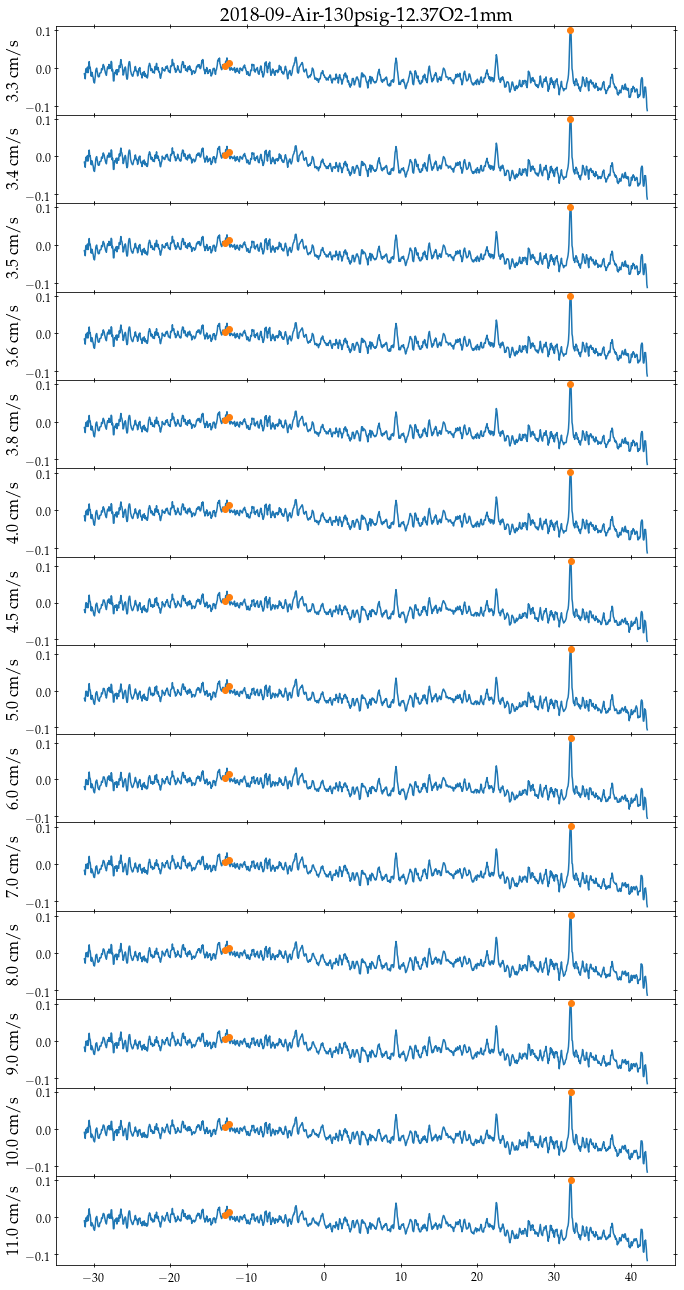

In [50]:
fig,ax = plt.subplots(len(test1),1,sharex=True)
fig.set_size_inches(10,20)
for j in range(n_vels1):     
    for i,k in zip(range(len(test1)),frames1.keys()):
        pci = frames1[k][j]
        ax[j].plot(pci.pos.x,pci.data['f430x10h'])
        x_flame = pci.x_flame
        print(x_flame,pci.T_flame)
        v_flame = pci.v_flame
        ax[0].set_title(title1[0].replace('_', '-'))
        ax[j].plot(x_flame,pci.v_flame,'o',linestyle='none')   
        ax[j].set_ylabel(str(v_f1[j])+' cm/s')
        ax[j].tick_params(labelsize=12)

C:\Users\Navid\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


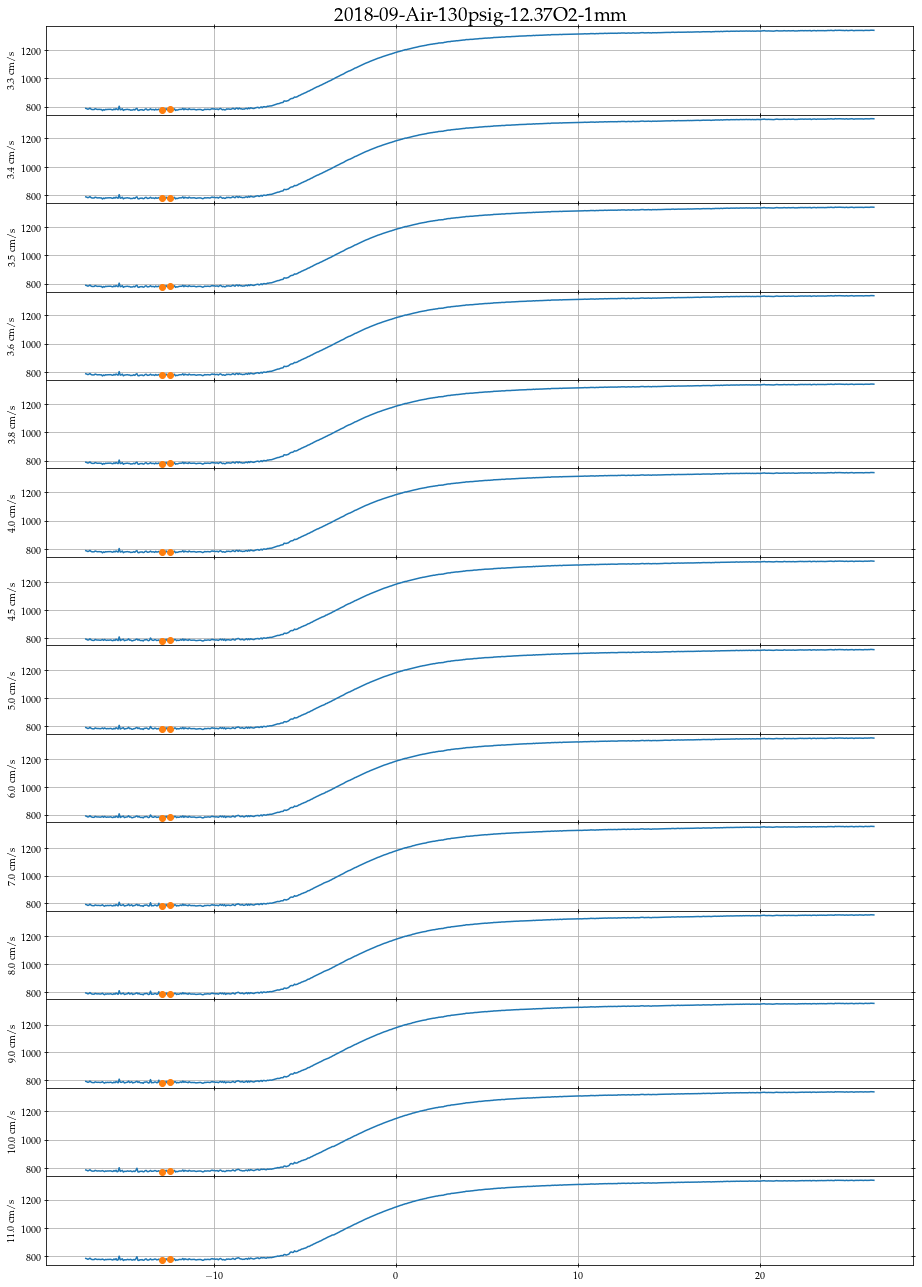

In [51]:
fig,ax = plt.subplots(n_vels1,1,sharex=True)
fig.set_size_inches(14,20)
for j in range(n_vels1):
    for i,k in zip(range(len(test1)),frames1.keys()):
        pci = frames1[k][j]    
        if pci.pyro is not None:      
            ax[j].plot(pci.pos.x, pci.pos.T)
            ax[j].grid(True,which='major')
            x_flame = pci.x_flame
            T_flame = pci.T_flame
            ax[0].set_title(title1[0].replace('_', '-'))
            ax[j].plot(x_flame,pci.T_flame,'o',linestyle='none') 
            ax[j].set_ylabel(str(v_f1[j])+' cm/s',fontsize = 10)
            ax[j].tick_params(labelsize=10)

In [52]:
def peak(array,a,b):
    c = np.amax(array[a:b])
    d = array.index(np.amax(array[a:b]))
    return c,d

In [53]:
def ext_i(array,low,high):
    c , d  = peak(list(array),low,high)
    j = np.amin(array[low:d])
    nxe = find_nearest_index(array[low:d],j)+low+2
    return nxe

In [54]:
def ign_i(array,low,high):
    c , d  = peak(list(array),low,high)
    j = np.amin(array[d:high])
    nxi = find_nearest_index(array[d:high],j)+d+5
    return nxi

In [55]:
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### Feature scaling

C:\Users\Navid\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


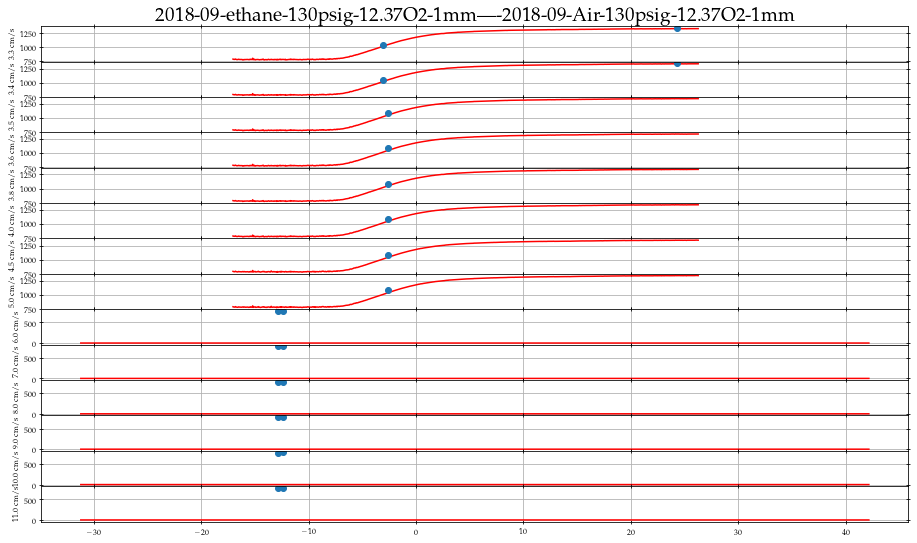

In [56]:
fig,ax = plt.subplots(n_vels2,1,sharex=True)
fig.set_size_inches(14,8)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["figure.dpi"] = 300
xl =-6
xu = 15
wtype = 'rbio3.1'
D_T_V = []
for j in range(n_vels2):
    for i,k in zip(range(len(test2)),frames2.keys()):
        pci2 = frames2[k][j]
        for l in range(n_vels1):
            for i,k in zip(range(len(test1)),frames1.keys()):
                pci1 = frames1[k][j]
                if pci1.pyro is not None and pci2.pyro is not None:  
                    if v_f1[l] ==  v_f2[j] and v_f1[l] < 6:
                        x1 = find_nearest_index(pci1.pos.x,xl)
                        x2 = find_nearest_index(pci1.pos.x,xu)
                        x_new = pci1.pos.x[x1:x2-1]
                        T1_new = pci1.pos.T[x1:x2-1]
                        T2_new = pci2.pos.T[x1:x2-1]
                        x = pci2.pos.x
                        v1= pci1.data['f430x10h']
                        v2 = pci2.data['f430x10h']
                        v3 = v2-v1
                        c = ext_i(v2, 0, 1200)
                        d = ign_i(v2, 430, 495)
                        s = [pci2.data['f430x10h'][c],pci2.data['f430x10h'][d]]
                        xxx = [pci2.pos.x[c],pci2.pos.x[d]]
                        tt = [pci2.pos.T[c],pci2.pos.T[d]]
                        ax[j].plot(x, pci1.pos.T, 'r', xxx, tt,'o')
                        ax[j].grid(True,which='major')         
                        ax[0].set_title(title2[0].replace('_', '-') + '----' + title1[0].replace('_', '-'))
                        ax[j].set_ylabel(str(v_f2[j])+' cm/s', fontsize = 8)
                        ax[j].tick_params(labelsize=8)
                    if v_f1[l] ==  v_f2[j] and v_f1[l] >= 6 and v_f1[l]<=10 :
                        x1 = find_nearest_index(pci.pos.x,xl)
                        x2 = find_nearest_index(pci.pos.x,xu)
                        x_new = pci.pos.x[x1:x2-1]
                        T1_new = pci1.pos.T[x1:x2-1]
                        T2_new = pci2.pos.T[x1:x2-1]
                        x = pci2.pos.x
                        v1= pci1.data['f430x10h']
                        v2 = pci2.data['f430x10h']
                        v3 = v2-v1
#                         c = ext_i(v2, 381, 505)
#                         d = ign_i(v2, 470, 505)
#                         s = [pci2.data['f430x10h'][c],pci2.data['f430x10h'][d]]
#                         xxx = [pci2.pos.x[c],pci2.pos.x[d]]
                        ax[j].plot(x, v2, 'r', pci.x_flame, pci.T_flame,'o')
                        ax[j].grid(True,which='major')         
                        ax[0].set_title(title2[0].replace('_', '-') + '----' + title1[0].replace('_', '-'))
                        ax[j].set_ylabel(str(v_f2[j])+' cm/s', fontsize = 8)
                        ax[j].tick_params(labelsize=8)
                    if v_f1[l] ==  v_f2[j] and v_f1[l] > 10:
                        x1 = find_nearest_index(pci.pos.x,xl)
                        x2 = find_nearest_index(pci.pos.x,xu)
                        x_new = pci.pos.x[x1:x2-1]
                        T1_new = pci1.pos.T[x1:x2-1]
                        T2_new = pci2.pos.T[x1:x2-1]
                        x = pci2.pos.x
                        v1= pci1.data['f430x10h']
                        v2 = pci2.data['f430x10h']
                        v3 = v2-v1
#                         c = ext_i(v2, 420, 445)
#                         d = ign_i(v2, 400, 445)
#                         s = [pci2.data['f430x10h'][c],pci2.data['f430x10h'][d]]
#                         xxx = [pci2.pos.x[c],pci2.pos.x[d]]
                        ax[j].plot(x, v2, 'r', pci.x_flame, pci.T_flame,'o')
                        ax[j].grid(True,which='major')         
                        ax[0].set_title(title2[0].replace('_', '-') + '----' + title1[0].replace('_', '-'))
                        ax[j].set_ylabel(str(v_f2[j])+' cm/s', fontsize = 8)
                        ax[j].tick_params(labelsize=8)
                    else:
                        continue

In [57]:
pci11 = frames1[title1[0]][7]
T11 = pci11.pos.T
x11 = pci11.pos.x

np.meanq

T111 = [T11[i] for i in range(len(T11)) if math.isnan(T11[i]) != True] 

x111 = [x11[i] for i in range(len(x11)) if math.isnan(T11[i]) != True] 

plt.plot(x111,T111)
plt.show()

AttributeError: module 'numpy' has no attribute 'meanq'

In [ ]:
def SNR(T):
    T1 = [T[i] for i in range(len(T)) if math.isnan(T[i]) != True]
    stdev = ss.stdev(T1)
    mean = np.mean(T1)
    snr = mean/stdev
    return snr

In [58]:
def wv_nr(T,x,xl,xu):
    x1 = find_nearest_index(x,xl)
    x2 = find_nearest_index(x,xu)
    x_new = x[x1:x2-1]
    x_wv = wavelet_domain(x_new)
    T_new = T[x1:x2-1]
    q = []
    ca = pw.wavedec(T_new,wtype,level=2)[0]
    x_wv, ca = equalize(x_wv, ca)
    x_wv = [x_wv[i] for i in range(len(x_wv)) if math.isnan(ca[i]) != True]
    ca = [ca[i] for i in range(len(ca)) if math.isnan(ca[i]) != True]
    FS = [np.nanmax(T_new)/np.max(ca)*ca[i] for i in range(len(ca))]
    f = np.column_stack((x_wv,FS))
    q = np.asarray(list(q) + list(f))
    q = sorted(q, key=itemgetter(0))
    ca_new = [q[i][1] for i in range(len(q))]
    x_wv_new = [q[i][0] for i in range(len(q))]
    return ca_new, x_wv_new

In [59]:
# x: position array
# y: temperature array
# s or b: smoothing parameter
# xnew: x position array that we want to plot new curve based on th interpolation on it.
def interpol(x,y,xnew,b):
    tck = interpolate.splrep(x, y, s=b)
    x_n = [xnew[i] for i in range(len(xnew)) if xnew[i]>x[0] and xnew[i]<x[-1]]
    ynew = interpolate.splev(x_n, tck, der=0)
    return ynew, x_n

NameError: name 'x111' is not defined

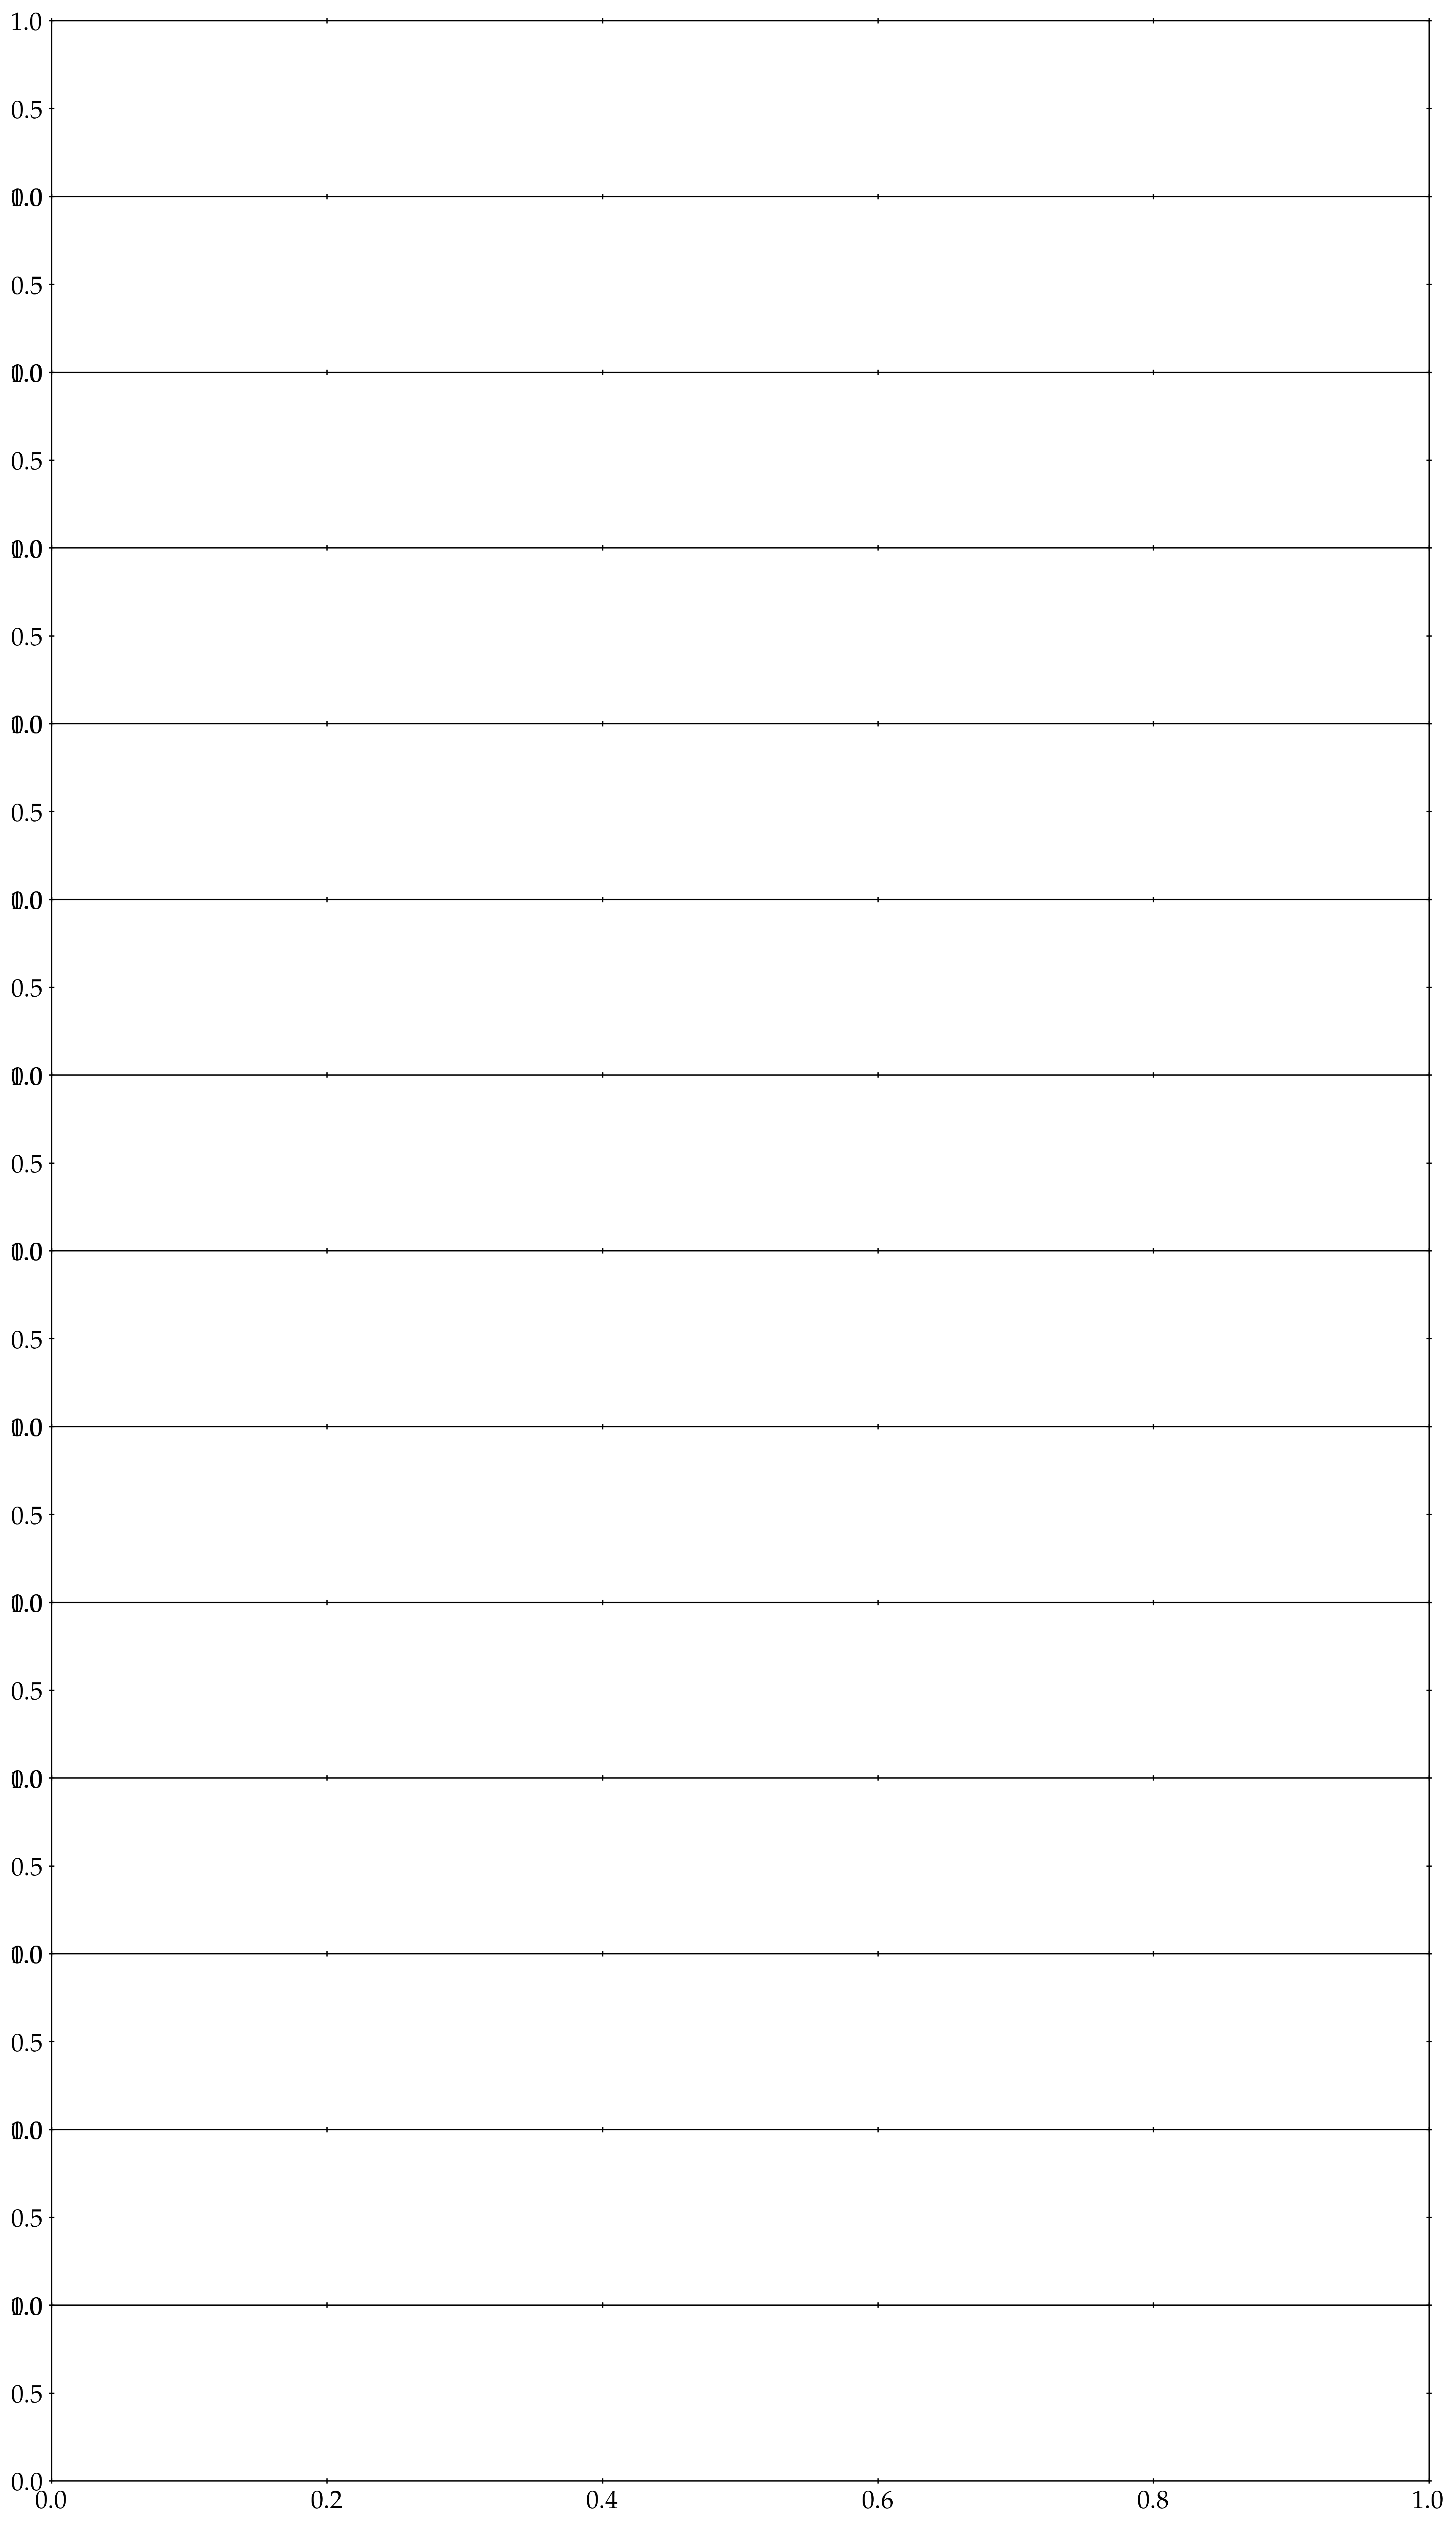

In [60]:
fig,ax = plt.subplots(n_vels2,1,sharex=True)
fig.set_size_inches(14,25)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["figure.dpi"] = 300
T_e =[]
T_i = []
T_ii = []
T_ee =[]
snr1 = []
snr_nr = []
snr_prime = []
wtype = 'rbio3.1'
xl = -6
xu = 10
ttt = []
x11 = find_nearest_index(x111,xl)
x22 = find_nearest_index(x111,xu)
for j in range(n_vels2):
    for i,k in zip(range(len(test2)),frames2.keys()):
        pci2 = frames2[k][j]
        for l in range(n_vels1):
            for i,k in zip(range(len(test1)),frames1.keys()):
                pci1 = frames1[k][j]
                if pci1.pyro is not None and pci2.pyro is not None:  
                    if v_f1[l] ==  v_f2[j] and v_f1[l] < 6:
                        x_1 = pci1.pos.x
                        x_2 = pci2.pos.x
                        T1= pci1.pos.T
                        v2 = pci2.data['f430x10h']
                        TC1 = [T1[i] for i in range(len(T1)) if math.isnan(T1[i]) != True]
                        snr1.append(SNR(TC1[100:]))
                        XC1 = [x_1[i] for i in range(len(T1)) if math.isnan(T1[i]) != True]
                        T2 = pci2.pos.T
                        T11 , x = wv_nr(T1,x_1,x_1[0],x_1[-1])
                        snr_prime.append(SNR(T11))
                        c = ext_i(pci2.data['f430x10h'], 385, 500)
                        d = ign_i(pci2.data['f430x10h'], 430, 500)
                        T_intp_a,x_new1_a = interpol(x,T11,XC1,100)
                        snr_nr.append(SNR(T_intp_a[100:]))
                        print(len(TC1),len(T_intp_a),len(x_new1_a),len(x),len(T11),len(x_1),len(XC1))
                        s = [T_intp_a[find_nearest_index(x_new1_a,x_1[c])],T_intp_a[find_nearest_index(x_new1_a,x_1[d])]]
                        x_ei = [x_1[c],x_1[d]]
                        T_e.append(s[0])
                        T_i.append(s[1])
                        ax[j].plot(x_2,v2)
                        #ax[j].plot(x_1,pci1.pos.T,'go',x_new1_a, T_intp_a,'ro',x_ei,s,'co')
                        ax[j].grid(True,which='major')         
                        ax[0].set_title(title2[0].replace('_', '-') + '----' + title1[0].replace('_', '-'))
                        ax[j].set_ylabel(str(v_f2[j])+' cm/s', fontsize = 8)
                        ax[j].tick_params(labelsize=8)
                    if v_f1[l] ==  v_f2[j] and v_f1[l] >= 6 and v_f1[l]<=10 :
                        x_1 = pci1.pos.x
                        x_2 = pci2.pos.x
                        T1= pci1.pos.T
                        v2 = pci2.data['f430x10h']
                        TC1 = [T1[i] for i in range(len(T1)) if math.isnan(T1[i]) != True]
                        snr1.append(SNR(TC1[100:]))
                        XC1 = [x_1[i] for i in range(len(T1)) if math.isnan(T1[i]) != True]
                        T2 = pci2.pos.T
                        T11 , x = wv_nr(T1,x_1,x_1[0],x_1[-1])
                        snr_prime.append(SNR(T11))
                        c = ext_i(pci2.data['f430x10h'], 385, 500)
                        d = ign_i(pci2.data['f430x10h'], 430, 500)
                        T_intp_a,x_new1_a = interpol(x,T11,XC1,100)
                        snr_nr.append(SNR(T_intp_a[100:]))
                        print(len(TC1),len(T_intp_a),len(x_new1_a),len(x),len(T11),len(x_1),len(XC1))
                        s = [T_intp_a[find_nearest_index(x_new1_a,x_1[c])],T_intp_a[find_nearest_index(x_new1_a,x_1[d])]]
                        x_ei = [x_1[c],x_1[d]]
                        T_e.append(s[0])
                        T_i.append(s[1])
                        ax[j].plot(x_2,v2)
                        #ax[j].plot(x_1,pci1.pos.T,'go',x_new1_a, T_intp_a,'ro',x_ei,s,'co')
                        ax[j].grid(True,which='major')         
                        ax[0].set_title(title2[0].replace('_', '-') + '----' + title1[0].replace('_', '-'))
                        ax[j].set_ylabel(str(v_f2[j])+' cm/s', fontsize = 8)
                        ax[j].tick_params(labelsize=8)
                    if v_f1[l] ==  v_f2[j] and v_f1[l] > 11:
                        x_1 = pci1.pos.x
                        T1= pci1.pos.T
                        T2 = pci2.pos.T
                        TC1 = [T1[i] for i in range(len(T1)) if math.isnan(T1[i]) != True]
                        XC1 = [x_1[i] for i in range(len(T1)) if math.isnan(T1[i]) != True]
                        snr1.append(SNR(TC1[100:]))
                        T11 , x = wv_nr(T1,x_1,x_1[0],x_1[-1])
                        snr_prime.append(SNR(T11))
                        T_intp_a,x_new1_a = interpol(x,T11,XC1,100)
                        T1 , x = wv_nr(T1,pci1.pos.x,pci1.pos.x[0],pci1.pos.x[-1])
                        T_intp_a,x_new1_a = interpol(x,T11,XC1,100)
                        snr_nr.append(SNR(T_intp_a[100:]))
                        x_flame = pci2.x_flame
                        T_flame = pci2.T_flame
                        T_intp_a,x_new1_a = interpol(x,T1,x_1,100) 
                        v2 = pci2.data['f430x10h']
                        nTm = np.where(pci1.pos.x == pci2.x_flame[0])
                        nTp = np.where(pci1.pos.x == pci2.x_flame[2])
                        
                        T_e1 = T_intp_a[find_nearest_index(x_new1_a,x_1[nTm])]
                        T_i1 = T_intp_a[find_nearest_index(x_new1_a,x_1[nTp])]
                        x_ei = [x_flame[0],x_flame[-1]]
                        s = [T_e1,T_i1]
                        if not T_i1: 
                            T_i.append(np.nan)
                        else:
                            T_i.append(T_i1)
                        if not T_e1:
                            T_e.append(np.nan)
                        else:
                            T_e.append(T_e1)
                        #ax[j].plot(x_1,pci1.pos.T,'go',x_new1_a, T_intp_a,'ro',x_ei,s,'co')
                        ax[j].plot(x_2,v2)
                        ax[j].grid(True,which='major')         
                        ax[0].set_title(title2[0].replace('_', '-') + '----' + title1[0].replace('_', '-'))
                        ax[j].set_ylabel(str(v_f2[j])+' cm/s', fontsize = 8)
                        ax[j].tick_params(labelsize=8)
                    else:
                        continue

In [ ]:
TC1[140]

In [ ]:
snr1 


In [ ]:
snr_nr

In [ ]:
diff = [abs(snr_nr[i]-snr1[i])/snr1[i]*100 for i in range(len(snr1))]

In [ ]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(v_f1,snr_nr, 'g',label = 'Correction')
ax1.plot(v_f1,snr1 ,'r', label='Original signal')
ax1.set_xlabel('velocity (cm/s)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('SNR', color='k')
ax1.tick_params('y', colors='k')
ax2 = ax1.twinx()
ax2.plot(v_f1, diff, 'b--',label='Percentage increase (\%)')
ax2.set_ylabel('Percentage increase (\%)')
ax2.tick_params('y')
ax1.legend(loc=(0.68,0.815),fontsize=10)
plt.legend(loc=(0.68,0.91),fontsize=10)
fig.tight_layout()
plt.show()

In [ ]:
T_i

In [ ]:
print(T_e)

### Three Ranges for velocity (3ed range uses old code for flame detection)

In [61]:
def cf(x,c0,a1,a2,a3):
    return c0+a1*sc.special.erf((x-a2)/(a3*np.sqrt(2)))
#initial guess for the coefficients
p0 = [ 873.37229087, -661.33344535,   -6.06710852,   -6.03648999]

In [62]:
# x: position array
# y: temperature array
# s or b: smoothing parameter
# xnew: x position array that we want to plot new curve based on th interpolation on it.
def interpol(x,y,xnew,b):
    tck = interpolate.splrep(x, y, s=b)
    x_n = [xnew[i] for i in range(len(xnew)) if xnew[i]>x[0] and xnew[i]<x[-1]]
    ynew = interpolate.splev(x_n, tck, der=0)
    return ynew, x_n

In [63]:
def del_extra(a,b,d1):
    a1 = []
    b1 = []
    d = d1
    a1.append(a[0])
    b1.append(b[0])
    for i in range(len(a)):
        c = a[i]+d
        e = find_nearest_index(a,c)
        if a[e]>a1[-1]+d1 and a[e]<0:
            a1.append(a[e])
            b1.append(b[e])
        if a[e]>0.1:
            if a[e]>a1[-1]+1*d1:
                a1.append(a[e])
                b1.append(b[e])
        else:
            continue
            
    return a1,b1

NameError: name 'x111' is not defined

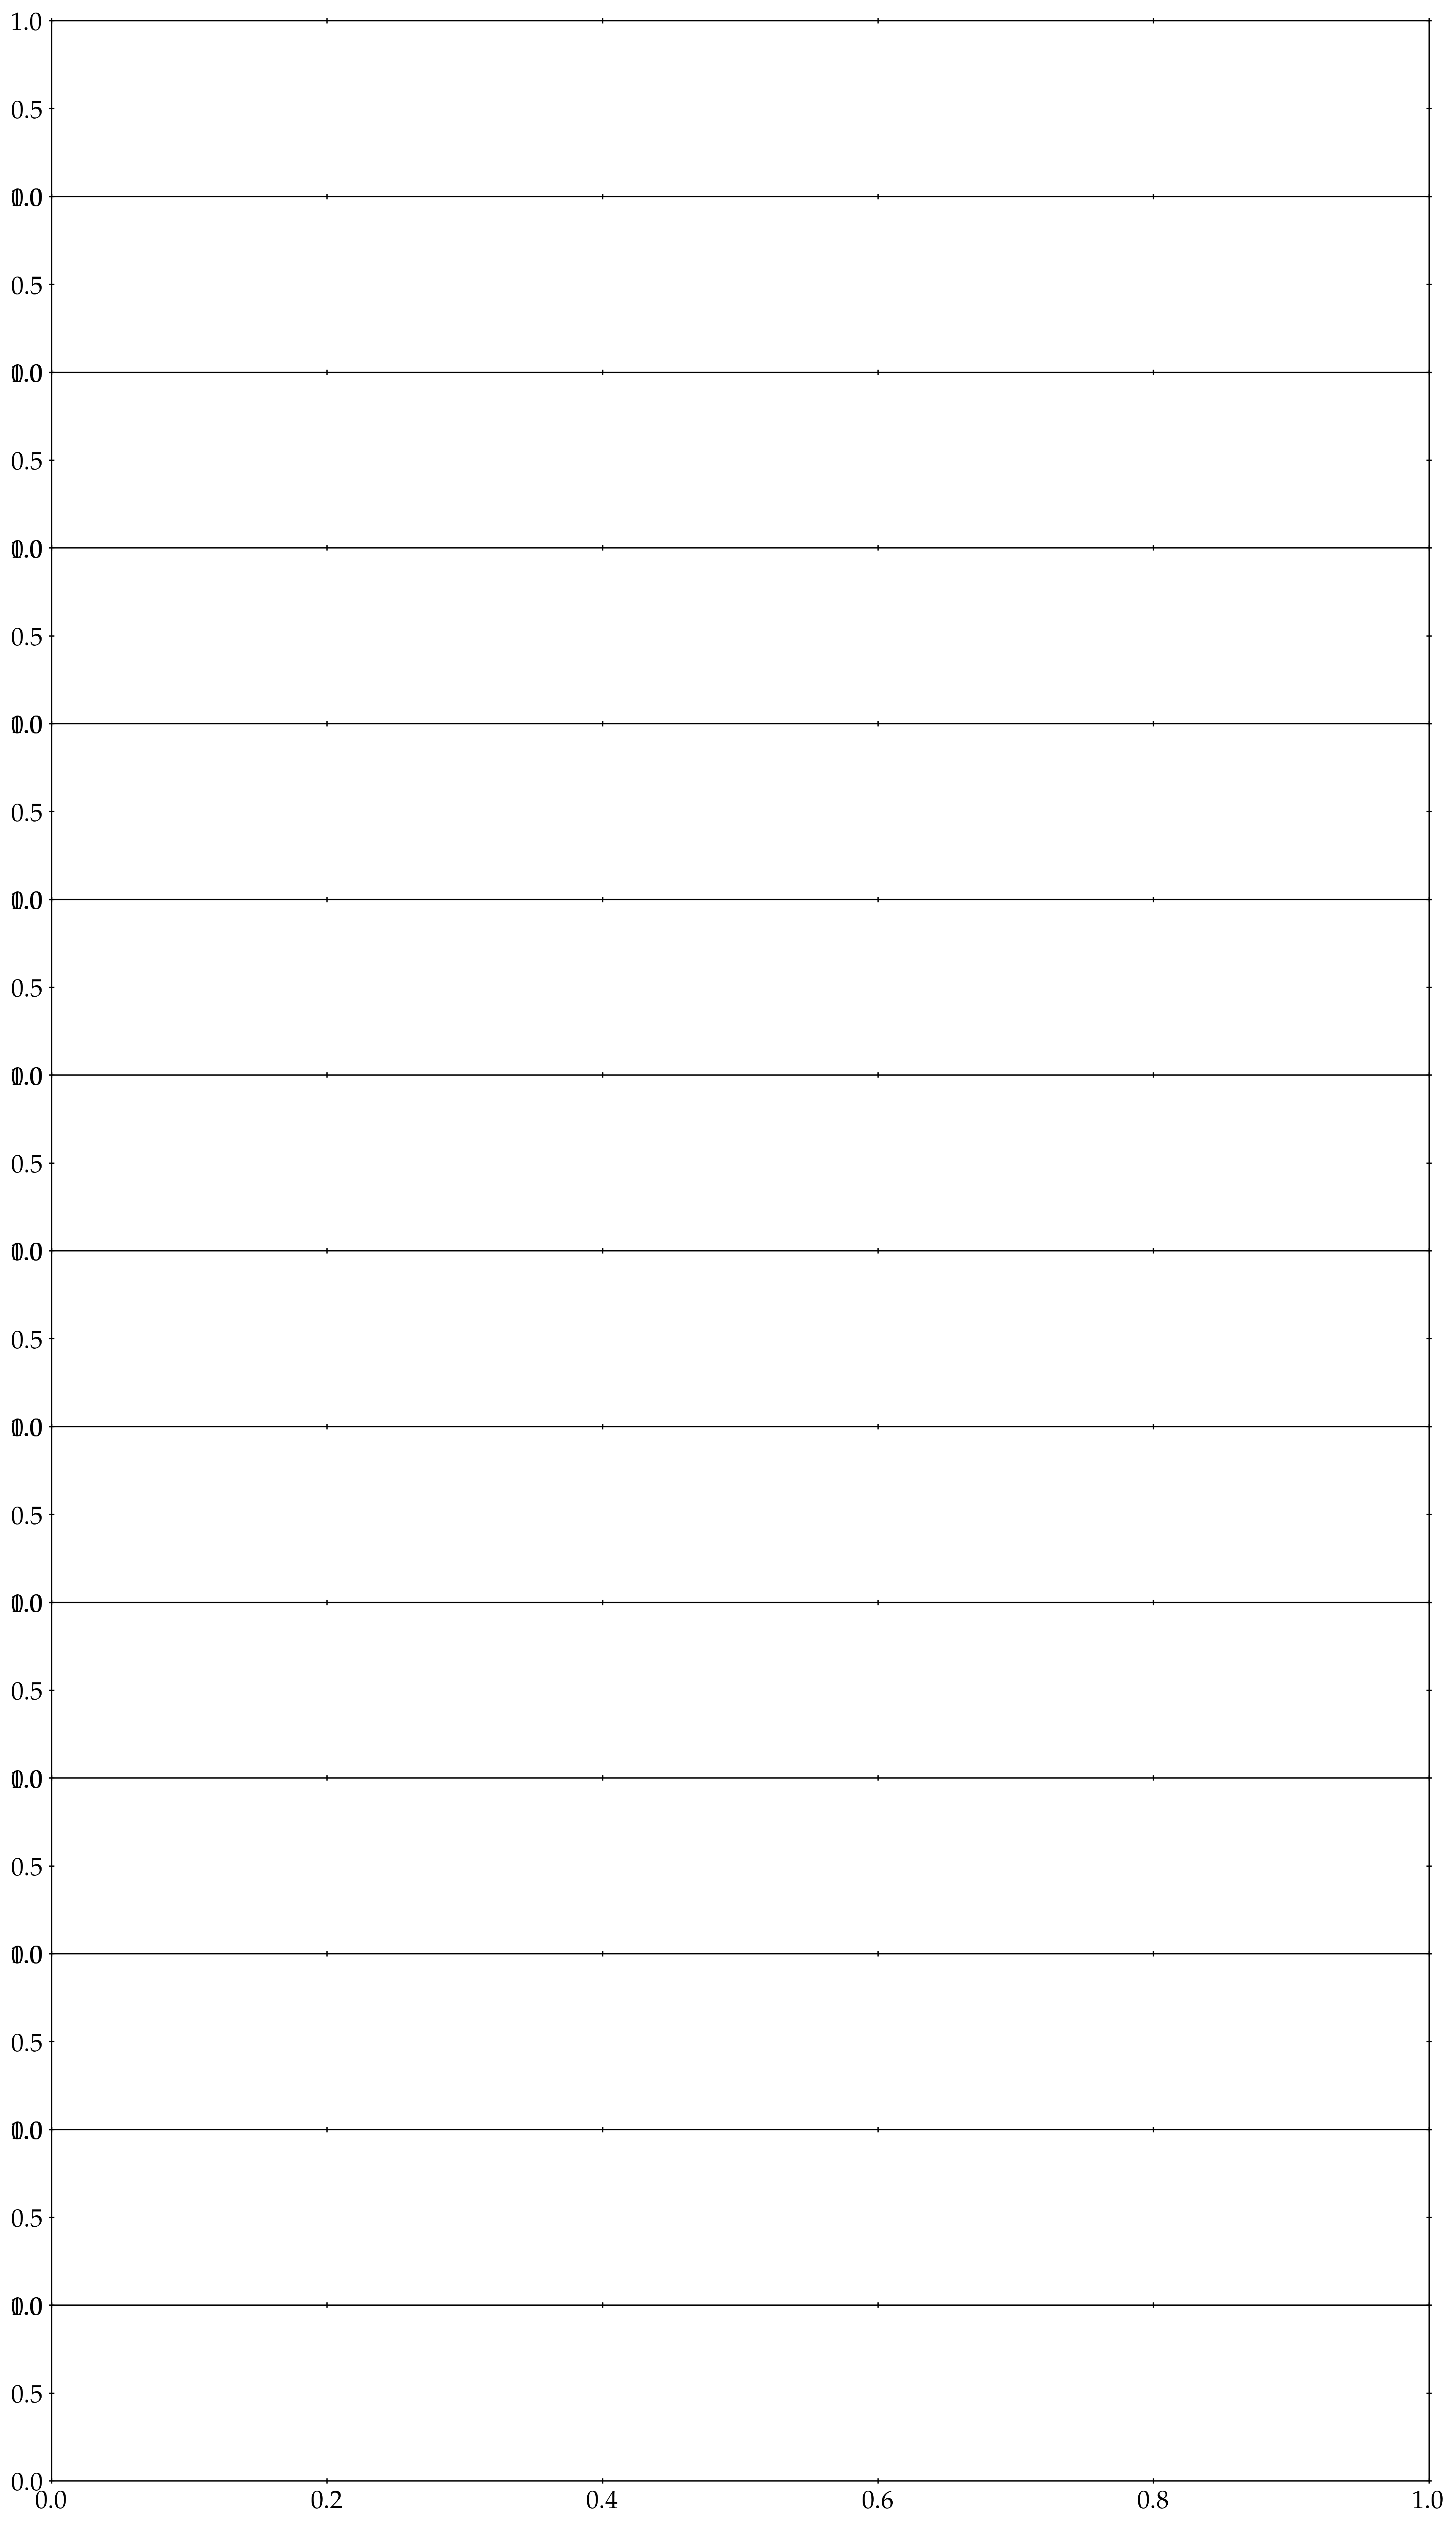

In [64]:
fig,ax = plt.subplots(n_vels2,1,sharex=True)
fig.set_size_inches(14,25)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["figure.dpi"] = 300
Tee = []
Tii = []
Te1 = []
Ti1 = []
Te11 = []
Ti11 = []
wtype = 'rbio3.1'
xl = -6
xu = 10
ttt = []
x11 = find_nearest_index(x111,xl)
x22 = find_nearest_index(x111,xu)
for j in range(n_vels2):
    for i,k in zip(range(len(test2)),frames2.keys()):
        pci2 = frames2[k][j]
        for l in range(n_vels1):
            for i,k in zip(range(len(test1)),frames1.keys()):
                pci1 = frames1[k][j]
                if pci1.pyro is not None and pci2.pyro is not None:  
                    if v_f1[l] ==  v_f2[j] and v_f1[l] < 6:
                        x = pci1.pos.x
                        T1= pci1.pos.T
                        T2 = pci2.pos.T
                        x_new = pci1.pos.x[x1:x2-1]
                        x1 = find_nearest_index(pci1.pos.x,xl)
                        x2 = find_nearest_index(pci1.pos.x,xu)
                        T1_new = pci1.pos.T[x1:x2-1]
                        T2_new = pci2.pos.T[x1:x2-1]
                        c = ext_i(pci2.data['f430x10h'], 385, 500)
                        d = ign_i(pci2.data['f430x10h'], 430, 500)
                        xxx = [pci2.pos.x[c],pci2.pos.x[d]]
                        s = [pci1.pos.T[c],pci1.pos.T[d]]
                        c2 = c
                        d2 = d
                        Tee.append(pci1.pos.T[c])
                        Tii.append(pci1.pos.T[d])
                        xxx = [pci2.pos.x[c],pci2.pos.x[d]]
                        ca , x_wv = wv(T2_new,x_new,xl,xu)
                        c,cov = curve_fit(cf,x111[x11:x22-1],T111[x11:x22-1],p0)
                        x_wv=np.asarray(x_wv)
                        T_c = cf(x_wv,c[0],c[1],c[2],c[3])
                        error = abs(T_c-ca)/T_c*100
                        gx = [x_wv[i] for i in range(len(error)) if error[i]<4]
                        g = [ca[i] for i in range(len(error)) if error[i]<4]
                        gx1,g1 = del_extra(gx,g,0.3)
                        T_intp,x_new1 = interpol(gx1,g1,x_new,101)
                        c1, con1 = curve_fit(cf,gx,g,p0)
                        ########################################
                        Te11.append(T_intp[find_nearest_index(x_new1,pci1.pos.x[c2])])
                        Ti11.append(T_intp[find_nearest_index(x_new1,pci1.pos.x[d2])])
                        ########
                        Te1.append(cf(xxx[0],c1[0],c1[1],c1[2],c1[3]))
                        Ti1.append(cf(xxx[1],c1[0],c1[1],c1[2],c1[3]))
                        T_n = cf(x_new,c1[0],c1[1],c1[2],c1[3])
                        ##########
                        ax[j].plot(x, T1,'b',x_new1,T_intp,'r--',x,T2,'k',xxx,s,'co')
                        ax[j].scatter(gx1,g1)
                        ax[j].grid(True,which='major')         
                        ax[0].set_title(title2[0].replace('_', '-') + '----' + title1[0].replace('_', '-'))
                        ax[j].set_ylabel(str(v_f2[j])+' cm/s', fontsize = 8)
                        ax[j].tick_params(labelsize=8)
                    if v_f1[l] ==  v_f2[j] and v_f1[l] >= 6 and v_f1[l]<=10 :
                        x = pci1.pos.x
                        T1= pci1.pos.T
                        T2 = pci2.pos.T
                        x1 = find_nearest_index(pci1.pos.x,xl)
                        x2 = find_nearest_index(pci1.pos.x,xu)
                        T1_new = pci1.pos.T[x1:x2-1]
                        T2_new = pci2.pos.T[x1:x2-1]
                        c = ext_i(pci2.data['f430x10h'], 381, 505)
                        d = ign_i(pci2.data['f430x10h'], 430, 500)
                        c2 = c
                        d2 = d
                        s = [pci1.pos.T[c],pci1.pos.T[d]]
                        xxx = [pci2.pos.x[c],pci2.pos.x[d]]
                        Tee.append(pci1.pos.T[c])
                        Tii.append(pci1.pos.T[d])
                        ca , x_wv = wv(T2_new,x_new,xl,xu)
                        c,cov = curve_fit(cf,x111[x11:x22-1],T111[x11:x22-1],p0)
                        x_wv=np.asarray(x_wv)
                        T_c = cf(x_wv,c[0],c[1],c[2],c[3])
                        error = abs(T_c-ca)/T_c*100
                        gx = [x_wv[i] for i in range(len(error)) if error[i]<2]
                        g = [ca[i] for i in range(len(error)) if error[i]<2]
                        gx1,g1 = del_extra(gx,g,0.3)
                        T_intp,x_new1 = interpol(gx1,g1,x_new,100)
                        c1, con1 = curve_fit(cf,gx,g,p0)
                        Te1.append(cf(xxx[0],c1[0],c1[1],c1[2],c1[3]))
                        Ti1.append(cf(xxx[1],c1[0],c1[1],c1[2],c1[3]))
                        T_n = cf(x_new,c1[0],c1[1],c1[2],c1[3])
                        Te11.append(T_intp[find_nearest_index(x_new1,pci1.pos.x[c2])])
                        Ti11.append(T_intp[find_nearest_index(x_new1,pci1.pos.x[d2])])
                        ax[j].plot(x, T1,'b',x_new1,T_intp,'r--',x,T2,'k',xxx,s,'co')
                        ax[j].scatter(gx1,g1)
                        ax[j].grid(True,which='major')         
                        ax[0].set_title(title2[0].replace('_', '-') + '----' + title1[0].replace('_', '-'))
                        ax[j].set_ylabel(str(v_f2[j])+' cm/s', fontsize = 8)
                        ax[j].tick_params(labelsize=8)
                    if v_f1[l] ==  v_f2[j] and v_f1[l] > 11:
                        x = pci1.pos.x
                        T1= pci1.pos.T
                        T2 = pci2.pos.T
                        x1 = find_nearest_index(pci1.pos.x,xl)
                        x2 = find_nearest_index(pci1.pos.x,xu)
                        T1_new = pci1.pos.T[x1:x2-1]
                        T2_new = pci2.pos.T[x1:x2-1]
                        x_flame = pci2.x_flame
                        T_flame = pci2.T_flame
                        
                        x_new = x[x1:x2-1]
                        nTm = np.where(pci1.pos.x == pci2.x_flame[0])
                        nTp = np.where(pci1.pos.x == pci2.x_flame[2])
                        Te = pci1.pos.T[nTm]
                        Ti = pci1.pos.T[nTp]
                        if not Ti: 
                            Tii.append(np.nan)
                        else:
                            Tii.append(Ti[0])
                        if not Te:
                            Tee.append(np.nan)
                        else:
                            Tee.append(Te[0])
                        T_air = [Te,Ti]
                        xxx = [x_flame[0],x_flame[2]]
                        ca , x_wv = wv(T2_new,x_new,xl,xu)
                        c,cov = curve_fit(cf,x111[x11:x22-1],T111[x11:x22-1],p0)
                        x_wv=np.asarray(x_wv)
                        T_c = cf(x_wv,c[0],c[1],c[2],c[3])
                        error = abs(T_c-ca)/ca*100
                        gx = [x_wv[i] for i in range(len(error)) if error[i]<1.5]
                        g = [ca[i] for i in range(len(error)) if error[i]<1.5]
                        gx1,g1 = del_extra(gx,g,0.4)
                        T_intp,x_new1 = interpol(gx1,g1,x_new,100)
                        c1, con1 = curve_fit(cf,gx,g,p0)
                        Te1.append(cf(xxx[0],c1[0],c1[1],c1[2],c1[3]))
                        Ti1.append(cf(xxx[1],c1[0],c1[1],c1[2],c1[3]))
                        T_n = cf(x_new,c1[0],c1[1],c1[2],c1[3])
                        Te11.append(T_intp[find_nearest_index(x_new1,x_flame[0])])
                        Ti11.append(T_intp[find_nearest_index(x_new1,x_flame[2])])
                        ax[j].plot(x, T1,'b',xxx,T_air,'co',x,T2,'k',x_new1,T_intp,'r--')
                        ax[j].scatter(gx1,g1)
                        ax[j].grid(True,which='major')         
                        ax[0].set_title(title2[0].replace('_', '-') + '----' + title1[0].replace('_', '-'))
                        ax[j].set_ylabel(str(v_f2[j])+' cm/s', fontsize = 8)
                        ax[j].tick_params(labelsize=8)
                    else:
                        continue

In [ ]:
a1=abs(np.array(Tii)-np.array(Ti1))

b1=abs(np.array(Tee)-np.array(Te1))

a2=abs(np.array(Tii)-np.array(Ti11))

b2=abs(np.array(Tee)-np.array(Te11))


plt.plot(v_f1,a1,'r',label='Ign erf')
plt.plot(v_f1,b1,'b',label='Ext erf')
plt.plot(v_f1,a2,'r--',label = 'Ign interpolation')
plt.plot(v_f1,b2,'b--',label='Ext interpolation')
plt.ylabel('T (k)')
plt.xlabel('Velocity (cm/s)')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:

a2

# b2=abs(np.array(Tee)-np.array(Te11))


In [ ]:
Tii

In [ ]:
Tee

In [ ]:
# Ti1

In [ ]:
# Te1

In [ ]:
# Te11

In [ ]:
# Ti11

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["figure.dpi"] = 300
er_e = [abs(Tee[i]-Te1[i])/Tee[i]*100 for i in range(len(Tee))]
er_i = [abs(Tii[i]-Ti1[i])/Tii[i]*100 for i in range(len(Tii))]
plt.plot(v_f2,er_e,'bo',v_f2,er_e, 'b',label = 'Extiction T')
plt.plot(v_f2,er_i,'ro',v_f2,er_i,'r',label = 'Ignition T')
plt.grid(True,which='major')
plt.title('Error (\%) for 5 bar condition (12.37\% O2)')
plt.ylabel('Error (\%)', fontsize = 8)
plt.xlabel('Velocity (cm)', fontsize = 8)
legend =plt.legend(facecolor ='white',loc='best', fontsize = 8,borderpad =2,frameon=True)

x = x_new
T = T1_new
def cf(x,c0,c1,c2,c3):
    return c0+c1*x+c2*x**2+c3*x**3
#initial guess for the coefficients
p0 = [ 1.16653367e+03,  3.63481158e+01, -2.95535009e+00,  7.99994392e-02]
c,cov = curve_fit(cf,x,T,p0)
print('Optimal parameters')
print(c)
Tp = cf(x,c[0],c[1],c[2],c[3])
plt.figure()
plt.title('Air temperature profile regression')
plt.plot(x,T,'r--',label = 'Measured')
plt.plot(x,Tp,'b-',label = 'Predicted')
plt.legend(loc='best')
plt.show()

In [ ]:
labels = {'xlabel':r'$v$ (cm/s)',
          'ylabel':r'Temperature $T$ (K)',
          'title':'',
          'legend':r'$\mathrm{CH^\star}$ (430 nm)',
          'legend2':r'v = 40 cm/s'}
limits = {'ylim':(900,1325,),
          'yticks':range(900,1400,50),
          'xlim':(0,90,),
          'xticks':range(0,100,10),
          'legend':'upper right'}
limits2 = {'ylim':(600,1325,),
          'yticks':range(600,1400,100),
          'xlim':(0,170,),
          'xticks':range(0,170,10),
          'legend':'upper right'}
limits3 = {'ylim':(950,1300,),
          'yticks':range(950,1300,10),
          'xlim':(0,1),
          'xticks':range(0,1,20),
          'legend':'lower right'}
#runs = np.unique(np.array(['nheptane']))
#runs = runs[np.argsort([ int(r[3:]) for r in runs ])][-1::-1]
#print(runs)
mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
plt.rcParams.update({'font.size': 16})
#col = mpl.rcParams['axes.color_cycle'] ## deprecated
col = [c['color'] for c in mpl.rcParams['axes.prop_cycle']]
leg_fsize = 10
lw = 1.7
col = ['blue','red']
#dashes = [(10., 0.1),(8.0, 2.0),(7.0, 2.0, 2.0, 2.0),(2.0, 2.0)]
dashes = [(8.0, 2.0),(10., 0.1),(7.0, 2.0, 2.0, 2.0),(4.0, 1.0)]
mv = MultipleLocator(25)
mh = MultipleLocator(5)

In [ ]:
mv = MultipleLocator(25)
mh = MultipleLocator(5)
ht= 6
fig,ax = plt.subplots(1,1)
fig.set_size_inches(5,3)
x=0
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['savefig.dpi'] = 500
ax.set_facecolor('none')
ax.set_ylim(700, 1700)
ax.set_xlabel('v(cm/s)', fontsize = 20) 
ax.yaxis.set_minor_locator(mv)
ax.xaxis.set_minor_locator(mh)
ax.plot(v_f1,Tii,
                   linewidth=lw,linestyle=(0,(5,1,1,1,1,1)),
                   color = 'r', markerfacecolor= 'none',
                   marker='^',markersize=7,
                   label='T+/12.37 O2')

ax.plot(v_f2,Tee,
                   linewidth=lw,linestyle=(0,(10,4)),
                   color = 'b',
                   marker='o',markersize=7,
                   markerfacecolor= 'none',
                   label='T-/12.37 O2')
ax.plot(v_f1,T_i,
                   linewidth=lw,linestyle=(0,(5,1,1,1,1,1)),
                   color = 'orange', markerfacecolor= 'none',
                   marker='^',markersize=7,
                   label='T+/12.37 O2 NR')

ax.plot(v_f2,T_e,
                   linewidth=lw,linestyle=(0,(10,4)),
                   color = 'g',
                   marker='o',markersize=7,
                   markerfacecolor= 'none',
                   label='T-/12.37 O2 NR')
ax.set_ylabel('Temperature (K)', fontsize = 20) 
ax.yaxis.set_minor_locator(mv)
ax.xaxis.set_minor_locator(mh)
leg = ax.legend()
leg.draw_frame(False)
leg.draw_frame(False)
leg = ax.legend(loc=limits2['legend'],prop={'size':leg_fsize},
                   title=labels['legend'])
leg.draw_frame(False)
leg.draw_frame(False)
plt.grid(b=None, which='major', axis='both')
plt.setp(leg.get_title(),fontsize=leg_fsize)